## 1. Import Libraries

In [51]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output='pandas')

In [4]:
warnings.filterwarnings('ignore')

## 3. Read the Data

In [5]:
path = r"/Users/vern/Projects/AeroTicker/data/train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-04-27,Delhi,Cochin,02:00:00,07:45:00,345,1.0,No Info,7173
1,Spicejet,2019-05-09,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No Info,3597
2,Spicejet,2019-06-06,Kolkata,Banglore,09:00:00,11:25:00,145,0.0,No check-in baggage included,3841
3,Air India,2019-05-12,Kolkata,Banglore,12:00:00,13:15:00,1515,1.0,No Info,6612
4,Multiple Carriers,2019-05-18,Delhi,Cochin,07:10:00,16:10:00,540,1.0,No Info,7038
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-03-03,Delhi,Cochin,06:40:00,15:30:00,530,1.0,No Info,14871
636,Air India,2019-04-01,Delhi,Cochin,17:20:00,09:25:00,965,1.0,No Info,5117
637,Spicejet,2019-04-01,Delhi,Cochin,06:05:00,11:20:00,315,1.0,No Info,5351
638,Vistara,2019-05-24,Kolkata,Banglore,20:20:00,10:45:00,865,1.0,No Info,9187


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

In [8]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 Airline

In [9]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with = "Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,0.0,0.0,1.0
638,0.0,0.0,0.0,0.0,1.0


### 4.2 Date of Journey

In [10]:
X_train.date_of_journey

0      2019-04-27
1      2019-05-09
2      2019-06-06
3      2019-05-12
4      2019-05-18
          ...    
635    2019-03-03
636    2019-04-01
637    2019-04-01
638    2019-05-24
639    2019-06-12
Name: date_of_journey, Length: 640, dtype: object

In [11]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
    ])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.333333,0.470588,0.833333,0.483051
1,0.666667,0.588235,0.500000,0.584746
2,1.000000,0.823529,0.500000,0.822034
3,0.666667,0.588235,1.000000,0.610169
4,0.666667,0.647059,0.833333,0.661017
...,...,...,...,...
635,0.000000,0.000000,1.000000,0.016949
636,0.333333,0.294118,0.000000,0.262712
637,0.333333,0.294118,0.000000,0.262712
638,0.666667,0.705882,0.666667,0.711864


### 4.3 Source and Destination

In [12]:
X_train.source

0        Delhi
1      Chennai
2      Kolkata
3      Kolkata
4        Delhi
        ...   
635      Delhi
636      Delhi
637      Delhi
638    Kolkata
639      Delhi
Name: source, Length: 640, dtype: object

In [13]:
X_train.destination

0        Cochin
1       Kolkata
2      Banglore
3      Banglore
4        Cochin
         ...   
635      Cochin
636      Cochin
637      Cochin
638    Banglore
639      Cochin
Name: destination, Length: 640, dtype: object

In [14]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Chennai,Kolkata
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Delhi,Cochin
638,Kolkata,Banglore


In [15]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.025247,1.021079
1,-1.878015,-0.758515
2,-0.154463,-0.188294
3,-0.154463,-0.188294
4,1.025247,1.021079
...,...,...
635,1.025247,1.021079
636,1.025247,1.021079
637,1.025247,1.021079
638,-0.154463,-0.188294


In [16]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_North": X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)
    

,source_is_North,destination_is_North
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [18]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)


,source,destination,source_is_North,destination_is_North
0,1.025247,1.021079,1,0
1,-1.878015,-0.758515,0,1
2,-0.154463,-0.188294,1,0
3,-0.154463,-0.188294,1,0
4,1.025247,1.021079,1,0
...,...,...,...,...
635,1.025247,1.021079,1,0
636,1.025247,1.021079,1,0
637,1.025247,1.021079,1,0
638,-0.154463,-0.188294,1,0


### 4.4 Dep Time and Arrival Time

In [19]:
X_train.dep_time

0      02:00:00
1      17:45:00
2      09:00:00
3      12:00:00
4      07:10:00
         ...   
635    06:40:00
636    17:20:00
637    06:05:00
638    20:20:00
639    02:15:00
Name: dep_time, Length: 640, dtype: object

In [20]:
X_train.arrival_time

0      07:45:00
1      20:05:00
2      11:25:00
3      13:15:00
4      16:10:00
         ...   
635    15:30:00
636    09:25:00
637    11:20:00
638    10:45:00
639    19:00:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset = X_train.loc[:,["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,02:00:00,07:45:00
1,17:45:00,20:05:00
2,09:00:00,11:25:00
3,12:00:00,13:15:00
4,07:10:00,16:10:00
...,...,...
635,06:40:00,15:30:00
636,17:20:00,09:25:00
637,06:05:00,11:20:00
638,20:20:00,10:45:00


In [22]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.086957,0.000000,0.304348,0.818182
1,0.739130,0.818182,0.869565,0.090909
2,0.391304,0.000000,0.478261,0.454545
3,0.521739,0.000000,0.565217,0.272727
4,0.304348,0.181818,0.695652,0.181818
...,...,...,...,...
635,0.260870,0.727273,0.652174,0.545455
636,0.739130,0.363636,0.391304,0.454545
637,0.260870,0.090909,0.478261,0.363636
638,0.869565,0.363636,0.434783,0.818182


In [23]:
def part_of_day(X, morning=4, noon=12, evening=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:,col].between(noon, evening, inclusive="left"),
                 X_temp.loc[:,col].between(evening, night, inclusive="left")],
                ["morning", "noon", "evening"],
                default="night")
        for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,morning
1,evening,night
2,morning,morning
3,noon,noon
4,morning,evening
...,...,...
635,morning,noon
636,evening,morning
637,morning,morning
638,night,morning


In [24]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.155660,0.981308
1,0.127358,1.000000
2,1.000000,0.981308
3,0.000000,0.000000
4,1.000000,0.560748
...,...,...
635,1.000000,0.000000
636,0.127358,0.981308
637,1.000000,0.981308
638,0.155660,0.981308


In [25]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)
    

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.086957,0.000000,0.304348,0.818182,0.155660,0.981308
1,0.739130,0.818182,0.869565,0.090909,0.127358,1.000000
2,0.391304,0.000000,0.478261,0.454545,1.000000,0.981308
3,0.521739,0.000000,0.565217,0.272727,0.000000,0.000000
4,0.304348,0.181818,0.695652,0.181818,1.000000,0.560748
...,...,...,...,...,...,...
635,0.260870,0.727273,0.652174,0.545455,1.000000,0.000000
636,0.739130,0.363636,0.391304,0.454545,0.127358,0.981308
637,0.260870,0.090909,0.478261,0.363636,1.000000,0.981308
638,0.869565,0.363636,0.434783,0.818182,0.155660,0.981308


### 4.5 Duration

In [26]:
X_train.duration

0       345
1       140
2       145
3      1515
4       540
       ... 
635     530
636     965
637     315
638     865
639    1005
Name: duration, Length: 640, dtype: int64

In [27]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1,1)
    #.shape
)

array([[175.],
       [520.],
       [920.]])

In [28]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5,0.75], gamma=0.1):
        self.variables= variables
        self.percentiles=percentiles
        self.gamma=gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        return self

    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)
        

In [29]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:, ["duration"]])
#RBFPercentileSimilarity(percentiles = [0.4. 0.8]).fit_transform(X_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.000000e+00,0.000000e+00
1,6.293989e-54,0.000000e+00,0.000000e+00
2,8.194013e-40,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,4.248354e-18,0.000000e+00
...,...,...,...
635,0.000000e+00,4.539993e-05,0.000000e+00
636,0.000000e+00,0.000000e+00,1.135971e-88
637,0.000000e+00,0.000000e+00,0.000000e+00
638,0.000000e+00,0.000000e+00,4.225900e-132


In [30]:
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                        X.duration.between(short, med, inclusive="left")],
                                       ["short", "medium"],
                                       default="long"))
        .drop(columns="duration")
    )
                

In [31]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

In [32]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
    
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method= "iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.35562,-0.138442,-0.097527,1.0,0,-0.592393
1,-0.35562,-0.138442,-0.097527,0.0,0,-0.994546
2,-0.35562,-0.138442,-0.097527,0.0,0,-0.984737
3,-0.35562,-0.138442,-0.097527,2.0,1,1.702819
4,-0.35562,-0.138442,-0.097527,2.0,0,-0.209858
...,...,...,...,...,...,...
635,-0.35562,-0.105457,-0.097527,2.0,0,-0.229475
636,-0.35562,-0.138442,-0.097527,2.0,0,0.623873
637,-0.35562,-0.138442,-0.097527,1.0,0,-0.651245
638,-0.35562,-0.138442,-0.097527,2.0,0,0.427701


### 4.6 Total Stops

In [34]:
X_train.total_stops

0      1.0
1      0.0
2      0.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    1.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [35]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,1.0,0


### 4.7 Additional Info

In [36]:
X_train.additional_info

0                           No Info
1                           No Info
2      No check-in baggage included
3                           No Info
4                           No Info
                   ...             
635                         No Info
636                         No Info
637                         No Info
638                         No Info
639                         No Info
Name: additional_info, Length: 640, dtype: object

In [37]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [38]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [39]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [40]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 4.8 Column Transformer

In [41]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_North,location__destination_is_North,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,1.025247,1.021079,1,0,0.086957,0.000000,0.304348,0.818182,0.155660,0.981308,-0.35562,-0.138442,-0.097527,1.0,0,-0.592393,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,1.0,0.666667,0.588235,0.500000,0.584746,-1.878015,-0.758515,0,1,0.739130,0.818182,0.869565,0.090909,0.127358,1.000000,-0.35562,-0.138442,-0.097527,0.0,0,-0.994546,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.500000,0.822034,-0.154463,-0.188294,1,0,0.391304,0.000000,0.478261,0.454545,1.000000,0.981308,-0.35562,-0.138442,-0.097527,0.0,0,-0.984737,0.0,1,0.0,0.0,1.0,1
3,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.154463,-0.188294,1,0,0.521739,0.000000,0.565217,0.272727,0.000000,0.000000,-0.35562,-0.138442,-0.097527,2.0,1,1.702819,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.833333,0.661017,1.025247,1.021079,1,0,0.304348,0.181818,0.695652,0.181818,1.000000,0.560748,-0.35562,-0.138442,-0.097527,2.0,0,-0.209858,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.025247,1.021079,1,0,0.260870,0.727273,0.652174,0.545455,1.000000,0.000000,-0.35562,-0.105457,-0.097527,2.0,0,-0.229475,1.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,1.025247,1.021079,1,0,0.739130,0.363636,0.391304,0.454545,0.127358,0.981308,-0.35562,-0.138442,-0.097527,2.0,0,0.623873,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,1.0,0.333333,0.294118,0.000000,0.262712,1.025247,1.021079,1,0,0.260870,0.090909,0.478261,0.363636,1.000000,0.981308,-0.35562,-0.138442,-0.097527,1.0,0,-0.651245,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,0.0,0.0,1.0,0.666667,0.705882,0.666667,0.711864,-0.154463,-0.188294,1,0,0.869565,0.363636,0.434783,0.818182,0.155660,0.981308,-0.35562,-0.138442,-0.097527,2.0,0,0.427701,1.0,0,0.0,1.0,0.0,0


## 5. Feature Selection

In [46]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [47]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.470588,0.483051,1.025247,1.021079,-0.35562,1.0,0,-0.592393,1.0,0
1,0.0,0.0,1.0,0.588235,0.584746,-1.878015,-0.758515,-0.35562,0.0,0,-0.994546,0.0,1
2,0.0,0.0,1.0,0.823529,0.822034,-0.154463,-0.188294,-0.35562,0.0,0,-0.984737,0.0,1
3,0.0,0.0,0.0,0.588235,0.610169,-0.154463,-0.188294,-0.35562,2.0,1,1.702819,1.0,0
4,0.0,0.0,0.0,0.647059,0.661017,1.025247,1.021079,-0.35562,2.0,0,-0.209858,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.000000,0.016949,1.025247,1.021079,-0.35562,2.0,0,-0.229475,1.0,0
636,0.0,0.0,0.0,0.294118,0.262712,1.025247,1.021079,-0.35562,2.0,0,0.623873,1.0,0
637,0.0,0.0,1.0,0.294118,0.262712,1.025247,1.021079,-0.35562,1.0,0,-0.651245,1.0,0
638,0.0,0.0,1.0,0.705882,0.711864,-0.154463,-0.188294,-0.35562,2.0,0,0.427701,1.0,0


## 7. Visualizations

In [53]:
preprocessor

,steps,"[('ct', ...), ('selector', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('air', ...), ('doj', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [56]:
preprocessor.named_steps

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='Other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

In [57]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [48]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.00793721638198915),
 'air__airline_Indigo': np.float64(0.10657289133145613),
 'air__airline_Jet Airways': np.float64(0.15950591844236642),
 'air__airline_Multiple Carriers': np.float64(0.006626068958294651),
 'air__airline_Other': np.float64(0.12567969249131292),
 'doj__date_of_journey_month': np.float64(0.07471635442198417),
 'doj__date_of_journey_week': np.float64(0.21351944463550632),
 'doj__date_of_journey_day_of_week': np.float64(-0.03166434214430325),
 'doj__date_of_journey_day_of_year': np.float64(0.1966068480701183),
 'location__source': np.float64(0.10791080038639489),
 'location__destination': np.float64(0.13274395821344318),
 'location__source_is_North': np.float64(0.03372266503222791),
 'location__destination_is_North': np.float64(0.03372266503222791),
 'time__dep_time_hour': np.float64(-0.050074217854221725),
 'time__dep_time_minute': np.float64(-0.00232090359165756),
 'time__arrival_time_hour': np.float64(0.0571803169621958),
 'time

In [49]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': np.float64(-0.050074217854221725),
 'doj__date_of_journey_day_of_week': np.float64(-0.03166434214430325),
 'time__dep_time_part_of_day': np.float64(-0.008197943462951293),
 'info__additional_info_In-flight meal not included': np.float64(-0.0032508651574154612),
 'dur__duration_rbf_75': np.float64(-0.00257669062806117),
 'time__dep_time_minute': np.float64(-0.00232090359165756),
 'info__additional_info_No Info': np.float64(0.00468449676590262),
 'info__additional_info': np.float64(0.00468449676590262),
 'air__airline_Multiple Carriers': np.float64(0.006626068958294651),
 'air__airline_Air India': np.float64(0.00793721638198915),
 'dur__duration_rbf_50': np.float64(0.010774850936152455),
 'time__arrival_time_minute': np.float64(0.01542440994377825),
 'time__arrival_time_part_of_day': np.float64(0.019484591731043888),
 'location__source_is_North': np.float64(0.03372266503222791),
 'location__destination_is_North': np.float64(0.03372266503222791),
 'info__additional

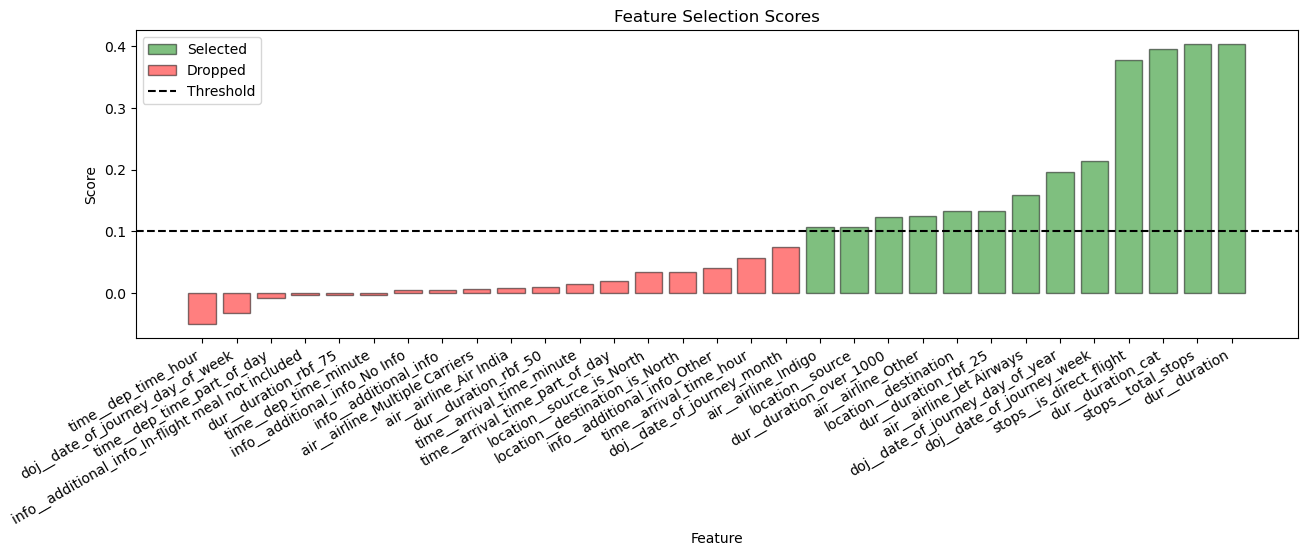

In [52]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that